In [140]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap




## Load and clean the data
#### Clean data - filter range and remove incomplete entries                                                           Aggregate and transform data - group and perform averaging

In [141]:

# read-in the excel spreadsheet using pandas 
df = pd.read_excel('Online_retail.xlsx', sheet_name='Online Retail')

# Remove  cancelled orders
df = df.loc[df['Quantity'] > 0]

# Remove any entries without CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Remove incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns of interest
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValue'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']


rank_df = customer_df.rank(method='first')
# normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df =  2* (rank_df - rank_df.mean()) / (rank_df.max() - rank_df.min())
# normalized_df.head(10)

colnames = list(normalized_df.columns[1:-1])
blobs = normalized_df

In [180]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2)) 

def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

def kmeans(dset, k, tol=1e-4):
    '''
    K-means implementation
    `dset`:  DataFrame with features
    `k`: number of clusters
    `tol`: numerical tolerance, default value of 1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    cset = [] # keep track for learning
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        if j % 10 == 0: # keep track for learning
            cset.append(centroids)
            
        j+=1
    print(j)
    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids, cset


In [181]:
np.random.seed(10)
k=4
df = blobs[['OrderCount','TotalSales','AvgOrderValue']]
centroids = initiate_centroids(k, df)
centroids

,OrderCount,TotalSales,AvgOrderValue
CustomerID,,,
16239.0,-0.038864,-0.283686,-0.359088
16557.0,-0.017454,-0.546195,-0.700256
15386.0,-0.635094,-0.313475,0.400512
14397.0,0.938562,0.640680,-0.756109


In [182]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
#df.head(40)

C:\Users\LongR\AppData\Local\Temp\ipykernel_15064\2129098451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['centroid'], df['error'] = centroid_assignation(df, centroids)
C:\Users\LongR\AppData\Local\Temp\ipykernel_15064\2129098451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['centroid'], df['error'] = centroid_assignation(df, centroids)


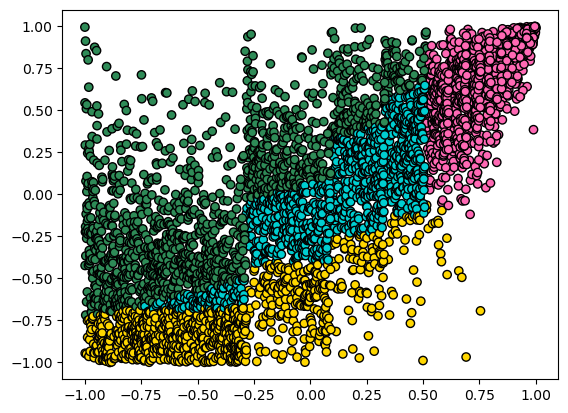

In [183]:
customcmap = ListedColormap(['darkturquoise','gold','seagreen','hotpink'])
plt.scatter(df.iloc[:,0], df.iloc[:,1],  c=df['centroid'].iloc[:], cmap=customcmap, edgecolor='k')

In [184]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 4099.04


In [185]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,OrderCount
0,0.110758
1,-0.361173
2,-0.419356
3,0.758299


In [186]:
np.random.seed(42)
df['centroid'], df['error'], centroids, cset =  kmeans(df[['OrderCount','TotalSales', 'AvgOrderValue']], 4)
df.head()


30


C:\Users\LongR\AppData\Local\Temp\ipykernel_15064\3197413084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['centroid'], df['error'], centroids, cset =  kmeans(df[['OrderCount','TotalSales', 'AvgOrderValue']], 4)


AttributeError: 'list' object has no attribute 'head'

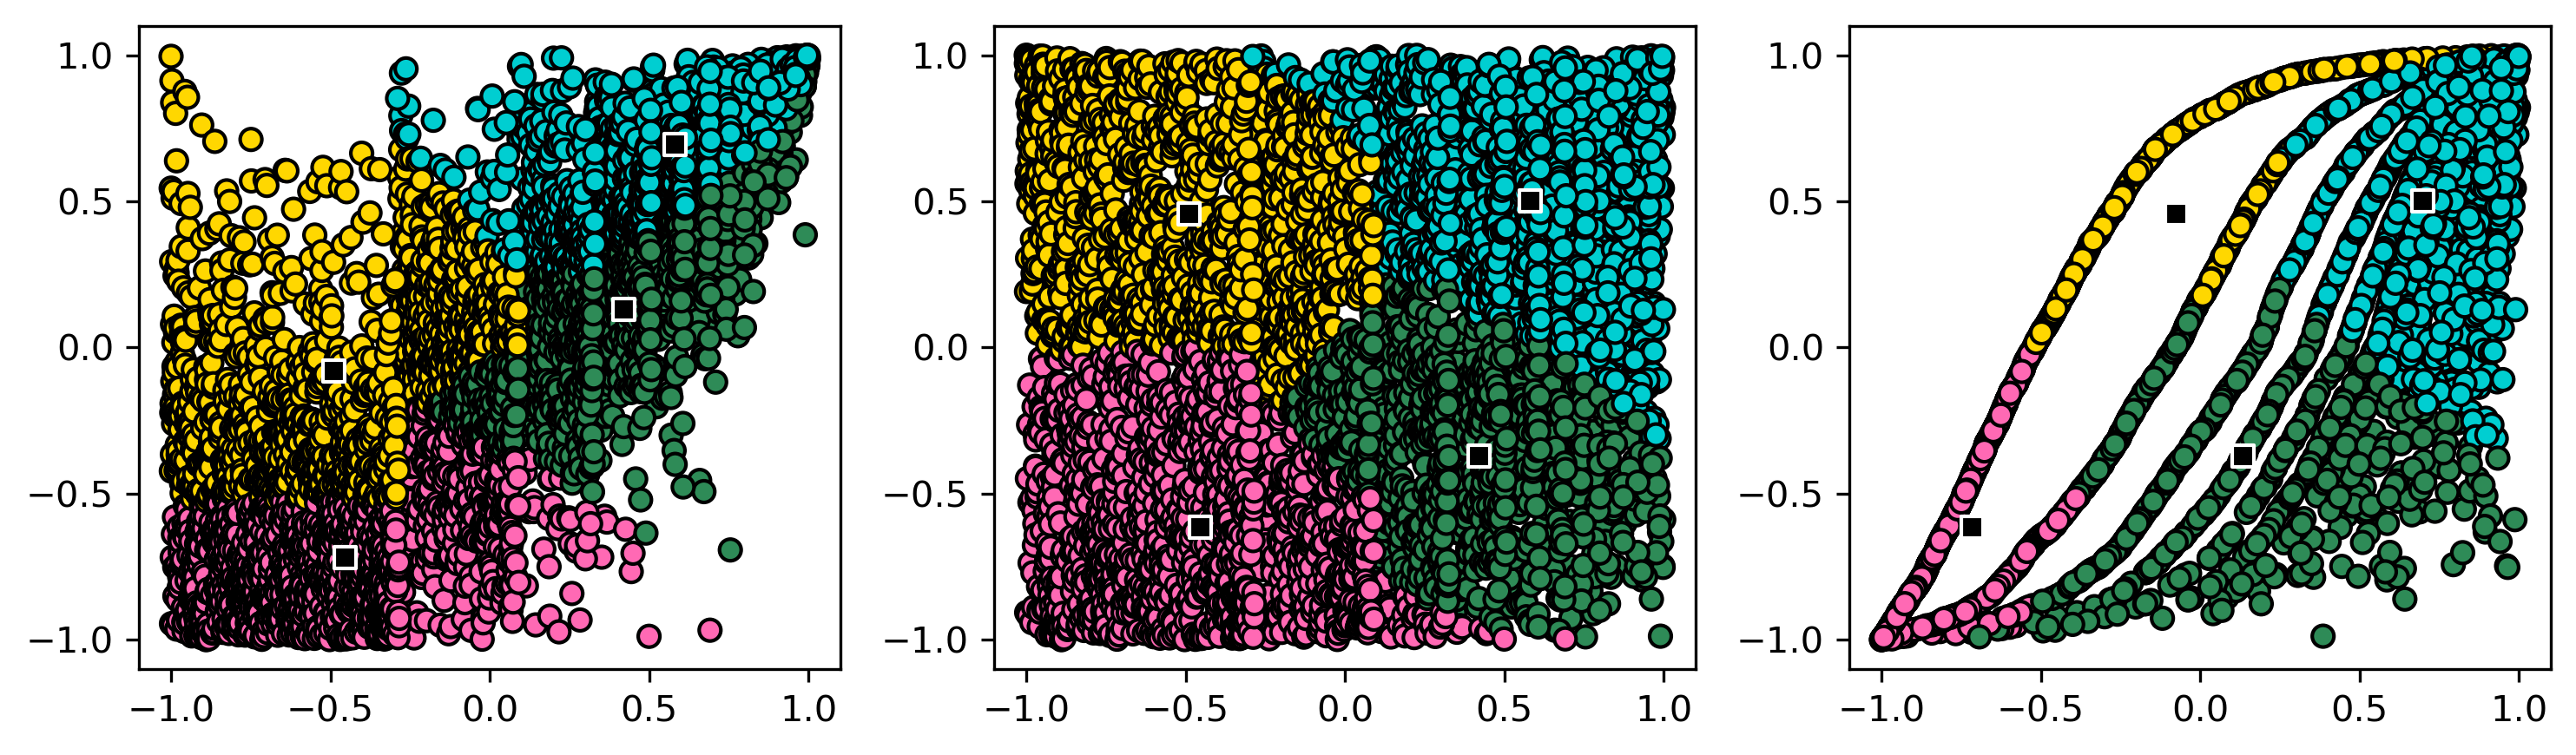

In [170]:
plt.figure(figsize=(10,3), dpi=300)
plt.subplot(1,3,1)
plt.scatter(df.iloc[:,0], df.iloc[:,1],  c=df['centroid'].iloc[:], cmap=customcmap, edgecolor='k')
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1], marker = 's', color='k', edgecolor='w')
plt.subplot(1,3,2)
plt.scatter(df.iloc[:,0], df.iloc[:,2],  c=df['centroid'].iloc[:], cmap=customcmap, edgecolor='k')
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,2], marker = 's', color='k', edgecolor='w')
plt.subplot(1,3,3)
plt.scatter(df.iloc[:,1], df.iloc[:,2],  c=df['centroid'].iloc[:], cmap=customcmap, edgecolor='k')
plt.scatter(centroids.iloc[:,1], centroids.iloc[:,2], marker = 's', color='k', edgecolor='w')
plt.tight_layout()
plt.show()

3
7
16


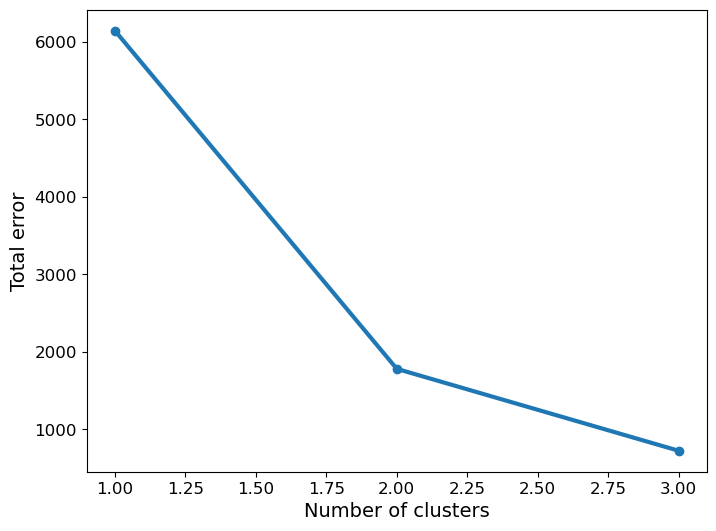

In [171]:
err_total = []
n = 3

df_elbow = blobs[['OrderCount','TotalSales','AvgOrderValue']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [200]:
cset

[   OrderCount  TotalSales  AvgOrderValue
 0    0.546451    0.343676      -0.131059
 1   -0.268281   -0.001675       0.344896
 2    0.062127   -0.696721      -0.887099
 3   -0.615629   -0.878388      -0.791965,
    OrderCount  TotalSales  AvgOrderValue
 0    0.597154    0.688247       0.449314
 1   -0.488444   -0.063336       0.478935
 2    0.355888    0.049868      -0.399182
 3   -0.487310   -0.733528      -0.610139,
    OrderCount  TotalSales  AvgOrderValue
 0    0.580943    0.696665       0.500953
 1   -0.491011   -0.076650       0.461278
 2    0.412502    0.125200      -0.371233
 3   -0.460729   -0.719894      -0.612822]

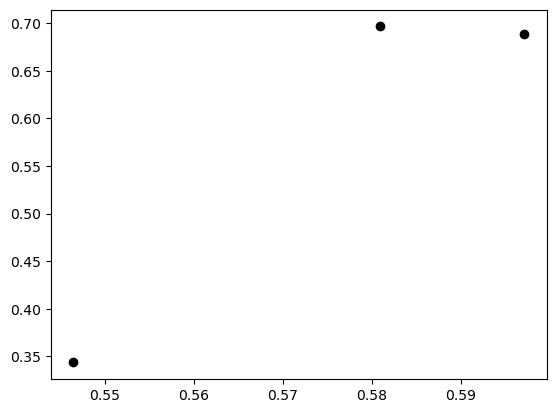

In [204]:
plt.figure()
for i in range(3):
    for j in range(1):
        plt.plot(cset[i].iloc[j,0],cset[i].iloc[j,1],'ko:')
plt.show()